# Scraping NYT Articles and using NLP methods 
This is to identify and learn about potential EdTech donors!  

In [1]:
# might need to use Beautiful Soup and Pickle for this work too.
import requests
import os
from pprint import pprint

#my usual suspects
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

import re
import string
import dateutil
from dateutil.relativedelta import relativedelta
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
nltk.download()
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


### Open a text file containing my API key

In [2]:
nyt_apikey = open('../nyt_apikey.txt','r')

In [3]:
file = nyt_apikey.read().splitlines()

In [4]:
myapikey = file[0]

In [5]:
apikey = os.getenv('NYTIMES_APIKEY', myapikey)

## Look up for current top stories
https://developer.nytimes.com/docs/top-stories-product/1/overview

In [ ]:
section = "education"
query_url = f"https://api.nytimes.com/svc/topstories/v2/{section}.json?api-key={apikey}"

r = requests.get(query_url)

#To see the json file:
#pprint(r.json())

## Article Search Endpoint
https://developer.nytimes.com/docs/articlesearch-product/1/routes/articlesearch.json/get

In [6]:
query = "education"
begin_date = "20210925" # YYYYMMDD
#filter_query = "\"body:(\"education\") AND glocations:(\"BOSTON\")\""
filter_query = "\"news_desk: (\"education\") AND body:(\"fundraising\") \""
page = "0" # <0-100>
sort = "relevance" # newest, oldest

query_url = f"https://api.nytimes.com/svc/search/v2/articlesearch.json?" \
f"q={query}" \
f"&api-key={apikey}" \
f"&begin_date={begin_date}" \
f"&fq={filter_query}" \
f"&page={page}" \
f"&sort={sort}" \

r = requests.get(query_url)

jsonfile = r.json()

#pprint(jsonfile)

In [7]:
jsonfile.keys()

dict_keys(['status', 'copyright', 'response'])

In [8]:
len(jsonfile['response']['docs'])

10

In [9]:
articles = jsonfile['response']['docs']
articles[0].keys()

dict_keys(['abstract', 'web_url', 'snippet', 'lead_paragraph', 'print_section', 'print_page', 'source', 'multimedia', 'headline', 'keywords', 'pub_date', 'document_type', 'news_desk', 'section_name', 'byline', 'type_of_material', '_id', 'word_count', 'uri'])

In [11]:
useful_kv = {'abstract': [],
        'web_url': [],
        'lead_paragraph': [],
        'headline': [],  
        'date': [], 
        'doc_type': [],
        'material_type': [],
        'keywords': []}

In [12]:
for article in articles:
    useful_kv['abstract'].append(article['abstract'])
    useful_kv['web_url'].append(article['web_url'])
    useful_kv['lead_paragraph'].append(article['lead_paragraph'])
    useful_kv['headline'].append(article['headline']['main'])
    useful_kv['date'].append(article['pub_date'])
    useful_kv['doc_type'].append(article['document_type'])
    useful_kv['material_type'].append(article['type_of_material'])
    
    keywords = [keyword['value'] for keyword in article['keywords'] if keyword['name'] == 'subject']
    useful_kv['keywords'].append(keywords)

### Transforming data into a Pandas data frame

In [14]:
df = pd.DataFrame(useful_kv) 

In [15]:
df['date'] = pd.to_datetime(df['date'])

In [16]:
df.head(2)

,abstract,web_url,lead_paragraph,headline,date,doc_type,material_type,keywords
0,Some districts have established robust virus t...,https://www.nytimes.com/2021/09/25/health/scho...,"SAN ANTONIO — One recent Thursday, Ciara Brown...","‘I Need an Army’: Across America, Schools Cram...",2021-09-25 13:00:13+00:00,article,News,"[your-feed-science, Education (K-12), Tests (M..."
1,The rulings were the second and third the last...,https://www.nytimes.com/2021/09/25/us/tennesse...,Two federal judges in Tennessee have dealt blo...,Two more federal judges rule against the Tenne...,2021-09-25 17:24:59+00:00,article,News,"[Special Education, Masks, Coronavirus (2019-n..."


### Cleaning the Data

#### Tokenization

In [166]:
#work with strings
join_abs = df['abstract'].str.cat(sep = '')
join_leadp = df['lead_paragraph'].str.cat(sep = '')
print(join_leadp[:100])

SAN ANTONIO — One recent Thursday, Ciara Brown, a junior at Fox Tech High School in San Antonio, ste


In [136]:
# #work with dataframes
# df['tok_abs'] = df['clean_abs'].apply(word_tokenize)

In [167]:
#alternative: work with strings
tok_abs = word_tokenize(join_abs)
tok_leadp = word_tokenize(join_leadp)

#### Punctuation and stopwords removal

In [168]:
# remove punctuation from the strings
tok_abs = [char for char in tok_abs if char not in string.punctuation]
tok_leadp = [char for char in tok_leadp if char not in string.punctuation]

In [169]:
#remove stopwords from the strings
stop_words = stopwords.words("english")
tok_abs = [char for char in tok_abs if char not in stop_words]
tok_leadp = [char for char in tok_leadp if char not in stop_words]

In [170]:
#remove words with one or two letters
tok_abs = [word for word in tok_abs if len(word)>2]
tok_leadp = [word for word in tok_leadp if len(word)>2]

In [171]:
tok_abs = [char.lower() for char in tok_abs]
tok_leadp = [char.lower() for char in tok_abs]

In [177]:
# make text lowercase, remove text in square brackets, remove punctuations, remove words containing numbers
def clean_text_round1(text):
    text = text.lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*','',text)
    return text

round1 = lambda x: clean_text_round1(x)

In [178]:
df['clean_abs'] = df['abstract'].apply(lambda x: clean_text_round1(x))

#### Create a Word Cloud
see the most frequent words in the abstract and lead paragraph

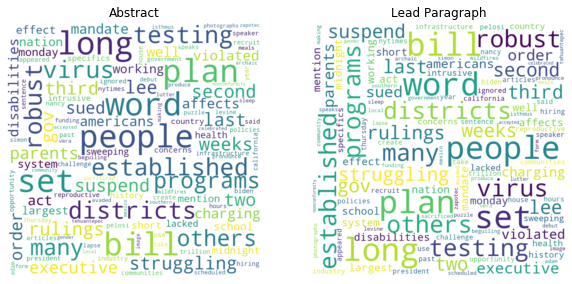

In [174]:
#plt.figure(figsize=(10,5), facecolor=None)
fig, axes = plt.subplots(1, 2, figsize=(10,5))

my_wc_1 = WordCloud(width = 800, height = 800, 
                  background_color ='white',
                  #background_color ='black', 
                  #stopwords = stop_words, 
                  min_font_size = 10,
                   max_font_size = 100)

my_wc_2 = WordCloud(width = 800, height = 800, 
                  background_color ='white',
                  #background_color ='black', 
                  #stopwords = stop_words, 
                  min_font_size = 10,
                   max_font_size = 100)

wordcloud_abs = my_wc_1.generate(' '.join(tok_abs))
wordcloud_leadp = my_wc_2.generate(' '.join(tok_leadp))

axes[0].imshow(wordcloud_abs, interpolation='bilinear')
axes[0].axis("off") 
axes[0].set_title("Abstract")
#axes[0].tight_layout(pad = 0) 

axes[1].imshow(wordcloud_leadp, interpolation='bilinear')
axes[1].axis("off") 
axes[1].set_title("Lead Paragraph")
#axes[1].tight_layout(pad = 0) 
plt.show()

# plt.subplot(1,2,2)
# plt.imshow(wordcloud_leadp, interpolation='bilinear')
# plt.axis("off") 
# plt.tight_layout(pad = 0) 

# plt.show()

In [196]:
for i in range(len(df)-1):
    freq_tok_abs = nltk.FreqDist(df['clean_abs'][i])
freq_tok_leadp = nltk.FreqDist(tok_leadp)

In [197]:
freq_tok_abs

FreqDist({' ': 18, 'e': 12, 'a': 12, 'i': 10, 'r': 8, 'd': 7, 'o': 6, 'l': 5, 't': 5, 's': 5, ...})

In [192]:
plt.figure(figsize=(10,8))

freq_tok_abs.plot(50)

AttributeError: 'list' object has no attribute 'plot'

<Figure size 720x576 with 0 Axes>

In [ ]:
#https://towardsdatascience.com/headlines-articles-analysis-and-nlp-4013a66dbac

In [ ]:
# combine abstract text
# def combine_text(text):
#     combined_text = ' '.join(text)
#     return combined_text
# df['abstract_combined'] = df['abstract'].apply(combine_text)

In [ ]:
# get rid of some additional punctuation and non=sensical text that was missed the first time around
def clean_text_round2(text):
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [ ]:
df['abstract_round2'] = df['abstract_round1'].apply(round2)

In [ ]:
df['abstract_round2']

In [ ]:
#https://github.com/adashofdata/nlp-in-python-tutorial/blob/master/1-Data-Cleaning.ipynb

### To-do list
- Term Frequency, Inverse Document Frequency (TFIDF)
- Tokenization
- Stop words
- Stemming
- Lemmatization
- Topic modeling (Latent Dirichlet Allocation)

